<a href="https://colab.research.google.com/github/rpavan07/BSA/blob/main/Land%20Cover/BlueSkyAnalytics_PostCOVID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install earthpy gdal

     |████████████████████████████████| 1.4 MB 8.3 MB/s 
     |████████████████████████████████| 1.0 MB 50.8 MB/s 
     |████████████████████████████████| 19.3 MB 8.4 MB/s 
     |████████████████████████████████| 6.3 MB 1.8 MB/s 
     |████████████████████████████████| 16.7 MB 36.6 MB/s 


In [2]:
from glob import glob
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import reshape_as_raster, reshape_as_image
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from scipy.io import loadmat
from sklearn.metrics import classification_report, accuracy_score
import plotly.graph_objects as go

from collections import Counter
from sklearn.cluster import KMeans
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import os
print(os.listdir("/content/drive/My Drive/BSA"))

Mounted at /content/drive
['post_pandemic', 'pre_pandemic', 'gir_pre', 'gir_post', 'pre_sundarbans', 'post_sundarbans', 'BlueSkyAnalytics_PreCOVID.ipynb', 'BlueSkyAnalytics_PostCOVID']


In [4]:
bands = glob("/content/drive/MyDrive/BSA/post_sundarbans/*B?*.TIF")
bands.sort()
bands

['/content/drive/MyDrive/BSA/post_sundarbans/LC08_L2SP_138045_20220207_20220212_02_T1_SR_B1.TIF',
 '/content/drive/MyDrive/BSA/post_sundarbans/LC08_L2SP_138045_20220207_20220212_02_T1_SR_B2.TIF',
 '/content/drive/MyDrive/BSA/post_sundarbans/LC08_L2SP_138045_20220207_20220212_02_T1_SR_B3.TIF',
 '/content/drive/MyDrive/BSA/post_sundarbans/LC08_L2SP_138045_20220207_20220212_02_T1_SR_B4.TIF',
 '/content/drive/MyDrive/BSA/post_sundarbans/LC08_L2SP_138045_20220207_20220212_02_T1_SR_B5.TIF',
 '/content/drive/MyDrive/BSA/post_sundarbans/LC08_L2SP_138045_20220207_20220212_02_T1_SR_B6.TIF']

In [5]:
dl = []
for j in bands:
  with rio.open(j,'r') as s:
    dl.append(s.read(1))

In [6]:
stack_array = np.stack(dl)

In [7]:
print(f'Width: {stack_array.shape[2]}\nHeight: {stack_array.shape[1]}\nBands: {stack_array.shape[0]}')

Width: 7561
Height: 7721
Bands: 6


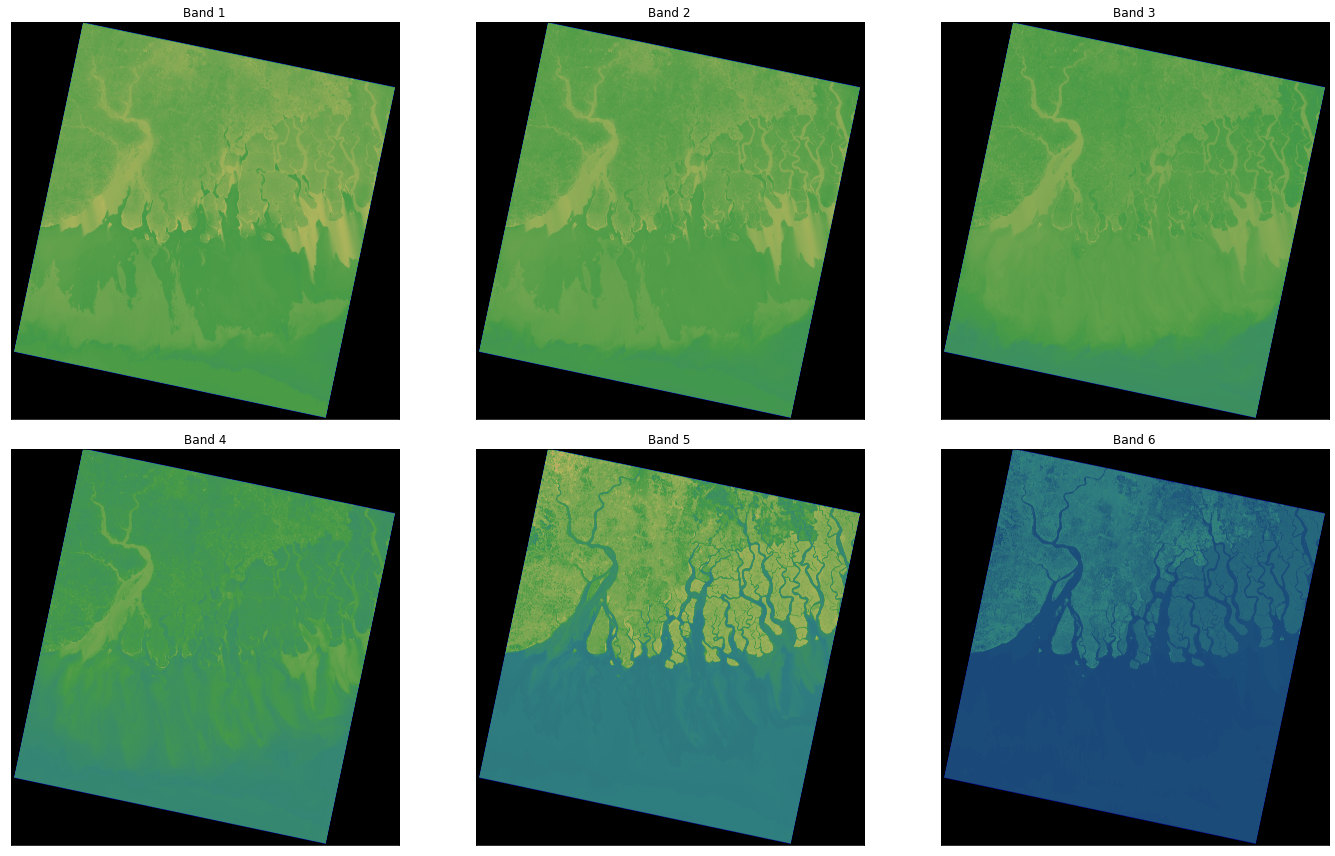

In [8]:
#visualizing data using earthpy and matplotlib
ep.plot_bands(stack_array, cmap = 'gist_earth', figsize = (20, 12), cols=3, cbar=False)
plt.show()

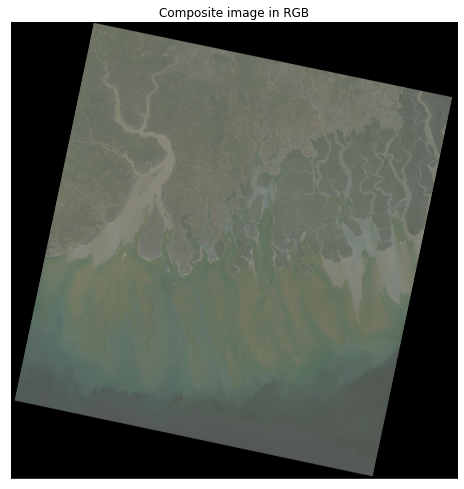

In [9]:
#rgb for band images
img = ep.plot_rgb(stack_array, rgb = (3,2,1), figsize= (8,10), title="Composite image in RGB")
plt.show()

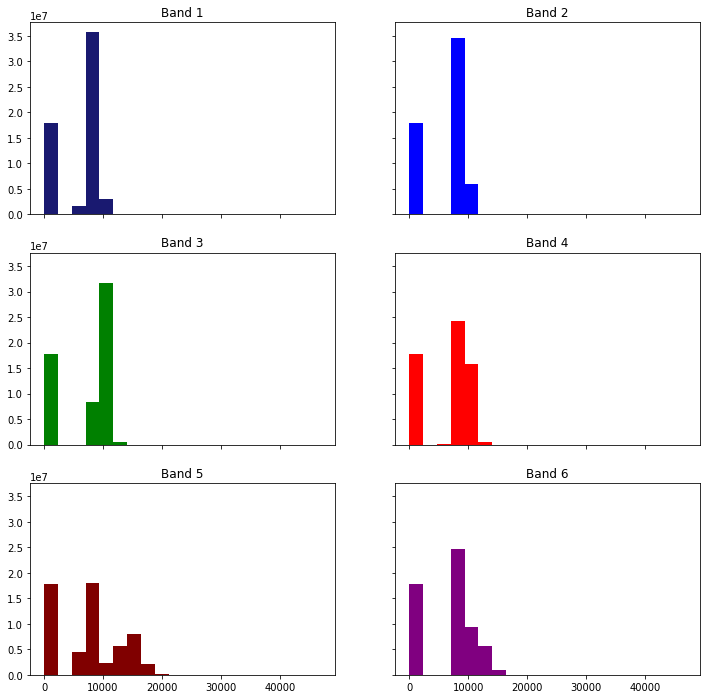

In [10]:
colors_list = [
    "midnightblue",
    "Blue",
    "Green",
    "Red",
    "Maroon",
    "Purple"]
titles = ['Band 1', 'Band 2', 'Band 3', 'Band 4', 'Band 5', 'Band 6']
ep.hist(stack_array, colors=colors_list, title = titles)
plt.show()

/usr/local/lib/python3.7/dist-packages/earthpy/spatial.py:105: RuntimeWarning: invalid value encountered in true_divide
  n_diff = (b1 - b2) / (b1 + b2)


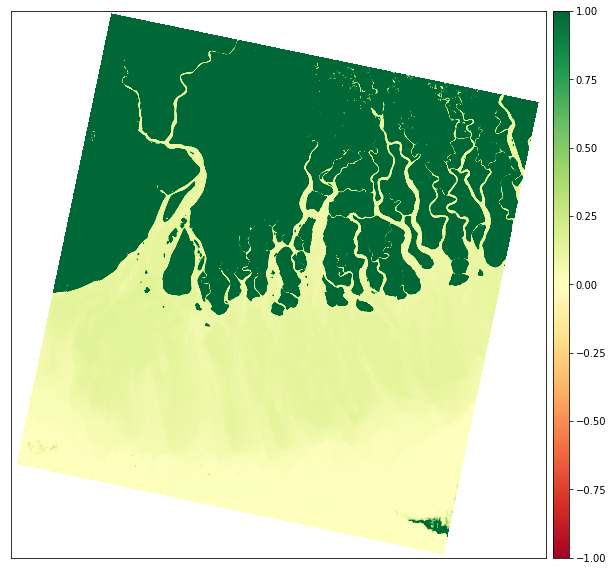

In [11]:
ndvi = es.normalized_diff(stack_array[3], stack_array[4])
ep.plot_bands(ndvi, cmap="RdYlGn", cols=1, vmin=-1, vmax=1, figsize=(10, 14))
plt.show()

In [12]:
ndvi_class_bins = [-np.inf, 0, 0.1, 0.25, 0.4, 0.5, 0.6, np.inf]
ndvi_landsat_class = np.digitize(ndvi, ndvi_class_bins)

# Apply the nodata mask to the newly classified NDVI data
ndvi_landsat_class = np.ma.masked_where(
    np.ma.getmask(ndvi), ndvi_landsat_class
)
np.unique(ndvi_landsat_class)

masked_array(data=[2, 3, 7, --],
             mask=[False, False, False,  True],
       fill_value=999999)

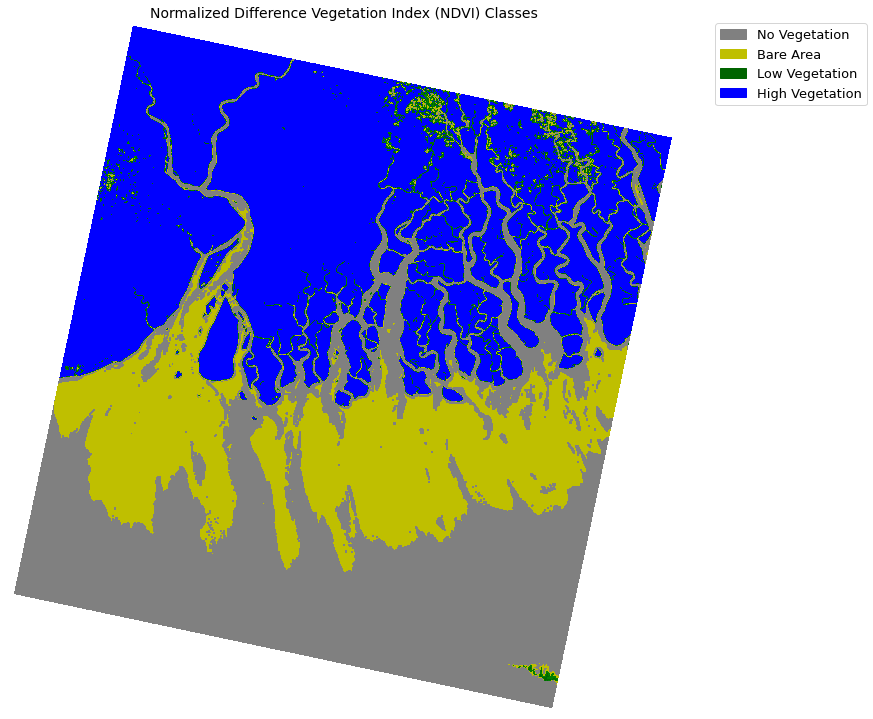

In [13]:
nbr_colors = ["gray", "y", "g", "darkgreen", "blue"]
nbr_cmap = ListedColormap(nbr_colors)


ndvi_cat_names = [
    "No Vegetation",
    "Bare Area",
    "Low Vegetation",
    "High Vegetation"
]

classes = np.unique(ndvi_landsat_class)
classes = classes.tolist()
classes = classes[0:5]

fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(ndvi_landsat_class, cmap=nbr_cmap)

ep.draw_legend(im_ax=im, classes=classes, titles=ndvi_cat_names)
ax.set_title(
    "Normalized Difference Vegetation Index (NDVI) Classes",
    fontsize=14,
)
ax.set_axis_off()
plt.tight_layout()

In [14]:
img = ndvi_landsat_class.reshape(ndvi_landsat_class.shape[0]*ndvi_landsat_class.shape[1],1)
img.shape

(58378481, 1)

In [15]:
sun_post = KMeans(n_clusters = 3)
color_labels = sun_post.fit_predict(img)
center_colors = sun_post.cluster_centers_

In [16]:
counts = Counter(color_labels)

In [17]:
label = ['No Vegetation', 'Bare-Area', 'Vegetation']
hex_colors = [ '#fffc9c','#9cd1ff','#9fff9c']

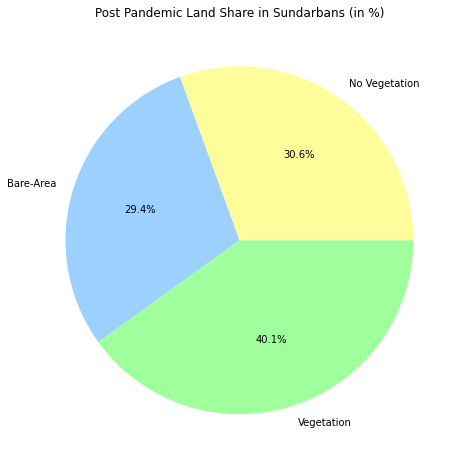

In [18]:
plt.figure(figsize = (12,8)) 
plt.pie(counts.values(), labels = label, colors = hex_colors, autopct='%1.01f%%')
plt.title("Post Pandemic Land Share in Sundarbans (in %)")
plt.show()

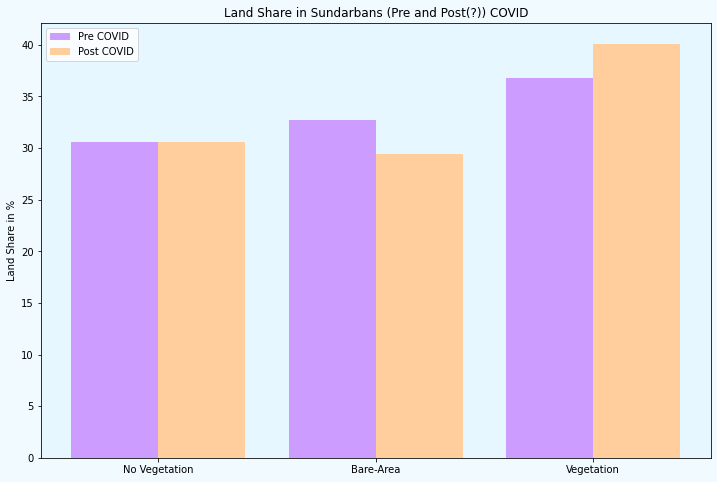

In [28]:
X = ['No Vegetation', 'Bare-Area', 'Vegetation']
pre_covid = [30.6, 32.7, 36.8]
post_covid = [30.6, 29.4, 40.1]

X_axis = np.arange(len(X))

fig = plt.figure(figsize = (12,8))
fig.patch.set_facecolor('#d1f0ff')
fig.patch.set_alpha(0.3)
ax = fig.add_subplot(111)
ax.patch.set_facecolor('#d1f0ff')
ax.patch.set_alpha(0.3)

plt.bar(X_axis - 0.2, pre_covid, 0.4, label = 'Pre COVID', color = "#cc9cff")
plt.bar(X_axis + 0.2, post_covid, 0.4, label = 'Post COVID', color = "#ffce9c")
plt.xticks(X_axis, X)
plt.ylabel("Land Share in %")
plt.title("Land Share in Sundarbans (Pre and Post(?)) COVID")
plt.legend()
plt.show()